## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt
import random

import json
import os.path
import gc

MODEL_FILE_NAME = 'model.txt'

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
comb_df = train_df.append(test_df)
songs_df = pd.read_csv('data/songs.csv')
song_extra_info_df = pd.read_csv('data/song_extra_info.csv')
members_df = pd.read_csv('data/members.csv')

In [3]:
def custom_cv(params, train_set, hold_out_set=None, k_fold=5, num_boost_round=20):
    x_train = train_set.data
    y_train = train_set.label
    n = x_train.shape[0]
    unit = n // k_fold

    cv_scores = []
    for k in range(k_fold):
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if k < k_fold - 1:
            continue
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        x_cv_valid = None
        y_cv_valid = None
        if k == k_fold - 1:
            x_cv_valid = x_train[unit * k:]
            y_cv_valid = y_train[unit * k:]
        else:
            x_cv_valid = x_train[unit * k: unit * (k + 1)]
            y_cv_valid = y_train[unit * k: unit * (k + 1)]

        x_cv_train = None
        y_cv_train = None
        if k == 0:
            x_cv_train = x_train[unit * (k + 1):]
            y_cv_train = y_train[unit * (k + 1):]
        elif k == k_fold - 1:
            x_cv_train = x_train[:unit * k]
            y_cv_train = y_train[:unit * k]
        else:
            x_cv_train = x_train[:unit * k].append(x_train[unit * (k + 1):])
            y_cv_train = y_train[:unit * k].append(y_train[unit * (k + 1):])

        cv_train_set = lgb.Dataset(x_cv_train, y_cv_train)
        cv_valid_set = lgb.Dataset(x_cv_valid, y_cv_valid)
        watchlist = [cv_valid_set]

        # not tested yet
        if hold_out_set is not None:
            watchlist.append(hold_out_set)
        model = lgb.train(params, train_set=cv_train_set, valid_sets=watchlist,
                          num_boost_round=num_boost_round, verbose_eval=5)
        print(model.best_score)
        cv_scores.append(model.best_score['valid_1']['auc'])

    tip_txt = '[CV]'
    tip_txt += ' ' + str(cv_scores)
    mean_cv_score = np.mean(cv_scores)
    tip_txt += '{ auc score=' + str(mean_cv_score) + ' }'
    print(tip_txt)

    return mean_cv_score

In [4]:
def custom_grid_search(params, own_grid_params, train_set, valid_set, num_boost_round=20):
    keys = []
    values = [list()]
    for key, value in own_grid_params.items():
        keys.append(key)
        new_values = []
        for item in values:
            for val in value:
                new_values.append(item + [val])
        values = new_values

    watchlist = [valid_set]
    grid_best_params = None
    grid_best_score = None

    for comb in values:
        own_params = {}
        for idx in range(len(keys)):
            own_params[keys[idx]] = comb[idx]
            params[keys[idx]] = comb[idx]

        cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=num_boost_round)

        tip_txt = '[GridSearch]'
        for idx in range(len(keys)):
            tip_txt += ' ' + str(keys[idx]) + '=' + str(comb[idx])
        tip_txt += ' { best_score: ' + str(cv_score) + ' }'
        print(tip_txt)

        if grid_best_score is None or cv_score > grid_best_score:
            grid_best_params, grid_best_score = own_params, cv_score

    tip_txt = '[GS Best Result]'
    for key, val in grid_best_params.items():
        tip_txt += ' ' + str(key) + '=' + str(val)
    tip_txt += ' { best_score: ' + str(grid_best_score) + ' }'
    print(tip_txt)
    
    return grid_best_params

## Pre-process train.csv & test.csv

In [5]:
def one_hot_encode_system_tab(x):
    return 1 if x == 'my library' else 0


def one_hot_encode_screen_name(x):
    return 1 if x == 'Local playlist more' or x == 'My library' else 0


def one_hot_encode_source_type(x):
    return 1 if x == 'local-library' or x == 'local-playlist' else 0


def one_hot_encode_source(x):
    return 1 if x >= 0.6 else 0

In [6]:
train_df['source_system_tab'].fillna('others', inplace=True)
test_df['source_system_tab'].fillna('others', inplace=True)

train_df['source_screen_name'].fillna('others', inplace=True)
test_df['source_screen_name'].fillna('others', inplace=True)

train_df['source_type'].fillna('nan', inplace=True)
test_df['source_type'].fillna('nan', inplace=True)

assert(~train_df.isnull().any().any())
assert(~test_df.isnull().any().any())

In [7]:
train_df['source_merged'] = train_df['source_system_tab'].map(str) + ' | ' + train_df['source_screen_name'].map(str) + ' | ' + train_df['source_type'].map(str) 
test_df['source_merged'] = test_df['source_system_tab'].map(str) + ' | ' + test_df['source_screen_name'].map(str) + ' | ' + test_df['source_type'].map(str) 

count_df = train_df[['source_merged', 'target']].groupby('source_merged').agg(['mean', 'count'])
count_df.reset_index(inplace=True)
count_df.columns = ['source_merged', 'source_replay_pb', 'source_replay_count']

In [8]:
train_df = train_df.merge(count_df, on='source_merged', how='left')
test_df = test_df.merge(count_df, on='source_merged', how='left')

train_df['1h_source'] = train_df['source_replay_pb'].apply(one_hot_encode_source)
test_df['1h_source'] = test_df['source_replay_pb'].apply(one_hot_encode_source)

train_df.drop(['source_merged', 'source_replay_pb', 'source_replay_count'], axis=1, inplace=True)
test_df.drop(['source_merged', 'source_replay_pb', 'source_replay_count'], axis=1, inplace=True)

train_df['1h_system_tab'] = train_df['source_system_tab'].apply(one_hot_encode_system_tab)
train_df['1h_screen_name'] = train_df['source_screen_name'].apply(one_hot_encode_screen_name)
train_df['1h_source_type'] = train_df['source_type'].apply(one_hot_encode_source_type)

test_df['1h_system_tab'] = test_df['source_system_tab'].apply(one_hot_encode_system_tab)
test_df['1h_screen_name'] = test_df['source_screen_name'].apply(one_hot_encode_screen_name)
test_df['1h_source_type'] = test_df['source_type'].apply(one_hot_encode_source_type)

# never drop, important
# train_df.drop(["source_system_tab", "source_screen_name", "source_type"], axis=1, inplace=True)
# test_df.drop(["source_system_tab", "source_screen_name", "source_type"], axis=1, inplace=True)

## Pre-process members.csv

In [9]:
def parse_str_to_date(date_str):
    # [format] yyyymmdd
    date_str = str(date_str)
    assert(isinstance(date_str, str))
    assert(len(date_str) == 8)
    
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:])
    return dt.date(year, month, day)
    
           
def transform_two_dates_to_days(row):
    start = parse_str_to_date(row['registration_init_time'])
    end = parse_str_to_date(row['expiration_date'])
    delta = end - start
    return delta.days


def transform_bd_outliers(bd):
    # figure is from "exploration"
    if bd >= 120 or bd <= 7:
        return 'nan'
    mean = 28.99737187910644
    std = 9.538470787507382
    return bd if abs(bd - mean) <= 3 * std else 'nan'


def transform_outliers(x, mean, std):
    return x if np.abs(x - mean) <= 3 * std else -1


def one_hot_encode_via(x):
    return 0 if x == 4 else 1


def transform_init_time_to_ym(time):
    time_str = str(time)
    year = int(time_str[:4])
    month = int(time_str[4:6])
    return int("%04d%02d" % (year, month))

# def custom_gender_random_seed(x):
#    if x is not np.nan:
#        return x
#    return random.choice(['female', 'male'])

In [10]:
members_df['membership_days'] = members_df.apply(transform_two_dates_to_days, axis=1)

members_df['registration_init_year'] = members_df['registration_init_time'].apply(lambda x: int(str(x)[:4]))
members_df['registration_init_month'] = members_df['registration_init_time'].apply(lambda x: int(str(x)[4:6]))

members_df['expiration_date_year'] = members_df['expiration_date'].apply(lambda x: int(str(x)[:4]))
members_df['expiration_date_month'] = members_df['expiration_date'].apply(lambda x: int(str(x)[4:6]))

members_df.drop(['registration_init_time'], axis=1, inplace=True)

members_df['bd'] = members_df['bd'].apply(transform_bd_outliers)

members_df['gender'].fillna('nan', inplace=True)

members_df['1h_via'] = members_df['registered_via'].apply(one_hot_encode_via)

assert(~members_df.isnull().any().any())
members_df.head(15)

,msno,city,bd,gender,registered_via,expiration_date,membership_days,registration_init_year,registration_init_month,expiration_date_year,expiration_date_month,1h_via
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,nan,nan,7,20170920,2223,2011,8,2017,9,1
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,nan,nan,7,20170622,725,2015,6,2017,6,1
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,nan,nan,4,20170712,457,2016,4,2017,7,0
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,nan,nan,9,20150907,1,2015,9,2015,9,1
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,nan,nan,4,20170613,138,2017,1,2017,6,0
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,43,female,9,20171006,1921,2012,7,2017,10,1
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,nan,nan,4,20160329,3,2016,3,2016,3,0
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,nan,nan,7,20170930,609,2016,1,2017,9,1
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,nan,nan,7,20170930,2454,2011,1,2017,9,1
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,nan,nan,7,20170613,482,2016,2,2017,6,1


## Pre-process song_extra_info.csv

In [11]:
# reference http://isrc.ifpi.org/en/isrc-standard/code-syntax
def transform_isrc_to_year(isrc):
    if type(isrc) != str:
        return np.nan
    # this year 2017
    suffix = int(isrc[5:7])
    
    return 1900 + suffix if suffix > 17 else 2000 + suffix


def transform_isrc_to_country(isrc):
    if type(isrc) != str:
        return np.nan
    country = isrc[:2]
    
    return country


def transform_isrc_to_reg(isrc):
    if type(isrc) != str:
        return np.nan
    registration = isrc[2:5]
    
    return registration


def transfrom_isrc_to_desig(isrc):
    if type(isrc) != str:
        return np.nan
    designation = isrc[7:]
    
    return designation


def one_hot_encode_year(x):
    return 1 if 2013 <= float(x) <= 2017 else 0


def one_hot_encode_country(x):
    return 1 if x == 'TW' or x == 'CN' or x == 'HK' else 0

In [12]:
song_extra_info_df['song_year'] = song_extra_info_df['isrc'].apply(transform_isrc_to_year)
# song_extra_info_df['song_country'] = song_extra_info_df['isrc'].apply(transform_isrc_to_country)
# song_extra_info_df['song_registration'] = song_extra_info_df['isrc'].apply(transform_isrc_to_reg)
# song_extra_info_df['song_designation'] = song_extra_info_df['isrc'].apply(transfrom_isrc_to_desig)

song_extra_info_df['1h_song_year'] = song_extra_info_df['song_year'].apply(one_hot_encode_year)
# song_extra_info_df['1h_song_country'] = song_extra_info_df['song_country'].apply(one_hot_encode_country)

song_extra_info_df.drop(['isrc', 'name'], axis=1, inplace=True)

song_extra_info_df['song_year'].fillna(2017, inplace=True)
# song_extra_info_df['song_registration'].fillna('***', inplace=True)

assert(~song_extra_info_df.isnull().any().any())
song_extra_info_df.head(15)

,song_id,song_year,1h_song_year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,2012.0,0
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,2016.0,1
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,2008.0,0
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,2013.0,1
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,2013.0,1
5,QU8f6JR0/cwLGSqJX2XDVzFK0DxMaIUY15ALJXK7ziw=,2014.0,1
6,O1Oj4CmnZhbHl7oyBaHSpGeu5gvcSmUydY3Awmv3uxk=,2007.0,0
7,Tr5R61AuEkN8UelOCzu09ZwQi7/HmP9sQmxf9rFngIg=,2004.0,0
8,ie9l12ZYXEaP4evrBBUvnNnZGdupHSX5NU+tEqB1SDg=,2002.0,0
9,6mICNlckUVGuoK/XGC7bnxXf5s2ZnkpFHShaGL/zM2Y=,2010.0,0


## Pre-process songs.csv

In [13]:
def parse_splitted_category_to_number(x):
    if x is np.nan:
        return 0
    
    x = str(x)
    x.replace('/', '|')
    x.replace(';', '|')
    x.replace('\\', '|')
    x.replace(' and ', '|')
    x.replace('&', '|')
    x.replace('+', '|')
    return x.count('|') + 1


def one_hot_encode_lang(x):
    return 1 if x in [-1, 17, 45] else 0

In [14]:
songs_df['genre_count'] = songs_df['genre_ids'].apply(parse_splitted_category_to_number)
songs_df['composer_count'] = songs_df['composer'].apply(parse_splitted_category_to_number)
songs_df['lyricist_count'] = songs_df['lyricist'].apply(parse_splitted_category_to_number)

songs_df['1h_lang'] = songs_df['language'].apply(one_hot_encode_lang)

songs_df['1h_song_length'] = songs_df['song_length'].apply(lambda x: 1 if x <= 239738 else 0)

songs_df['language'].fillna('nan', inplace=True)
songs_df['composer'].fillna('nan', inplace=True)
songs_df['lyricist'].fillna('nan', inplace=True)
songs_df['genre_ids'].fillna('nan', inplace=True)
# songs_df.drop(['language'], axis=1, inplace=True)
assert(~songs_df.isnull().any().any())
songs_df.head(15)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,genre_count,composer_count,lyricist_count,1h_lang,1h_song_length
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3,1,1,1,0,0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31,1,3,1,0,1
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,nan,nan,31,1,0,0,0,1
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3,1,1,1,0,0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52,1,1,1,0,1
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17,4,1,1,1,1
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,nan,3,1,1,0,0,1
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3,1,1,1,0,0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3,1,1,1,0,1
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52,2,5,5,0,1


In [15]:
count_df = train_df['song_id'].value_counts().reset_index()
count_df.columns = ['song_id', 'play_count']

train_df = train_df.merge(count_df, on='song_id', how='left')
train_df['play_count'].fillna(0, inplace=True)

count_df = comb_df['song_id'].value_counts().reset_index()
count_df.columns = ['song_id', 'play_count']

test_df = test_df.merge(count_df, on='song_id', how='left')
test_df['play_count'].fillna(0, inplace=True)

## Merge all dataframes

In [16]:
songs_df = songs_df.merge(song_extra_info_df, on='song_id', how='left')

train_df = train_df.merge(songs_df, on='song_id', how='left')
test_df = test_df.merge(songs_df, on='song_id', how='left')

train_df = train_df.merge(members_df, on='msno', how='left')
test_df = test_df.merge(members_df, on='msno', how='left')

train_df.info()
test_df.info()

for column in train_df.columns:
    if train_df[column].dtype == object:
        train_df[column] = train_df[column].astype('category')
for column in test_df.columns:
    if test_df[column].dtype == object:
        test_df[column] = test_df[column].astype('category')

x = train_df.drop(['target'], axis=1)
y = train_df['target']

# take appropriate data to train
# x = train_df.drop(['target'], axis=1).head(train_df.shape[0] - test_df.shape[0])
# y = train_df['target'].head(train_df.shape[0] - test_df.shape[0]).values

# take the last # rows of train_df as valid set where # means number of rows in test_df
x_valid = train_df.drop(['target'], axis=1).tail(test_df.shape[0])
y_valid = train_df['target'].tail(test_df.shape[0])

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id']

train_df.head(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 35 columns):
msno                       object
song_id                    object
source_system_tab          object
source_screen_name         object
source_type                object
target                     int64
1h_source                  int64
1h_system_tab              int64
1h_screen_name             int64
1h_source_type             int64
play_count                 int64
song_length                float64
genre_ids                  object
artist_name                object
composer                   object
lyricist                   object
language                   object
genre_count                float64
composer_count             float64
lyricist_count             float64
1h_lang                    float64
1h_song_length             float64
song_year                  float64
1h_song_year               float64
city                       int64
bd                         object
ge

,msno,song_id,source_system_tab,source_screen_name,source_type,target,1h_source,1h_system_tab,1h_screen_name,1h_source_type,...,bd,gender,registered_via,expiration_date,membership_days,registration_init_year,registration_init_month,expiration_date_year,expiration_date_month,1h_via
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,0,0,0,0,...,nan,nan,7,20171005,2103,2012,1,2017,10,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,1,1,1,1,...,24,female,9,20170911,2301,2011,5,2017,9,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,1,1,1,1,...,24,female,9,20170911,2301,2011,5,2017,9,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,1,1,1,1,...,24,female,9,20170911,2301,2011,5,2017,9,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,0,0,0,0,...,nan,nan,7,20171005,2103,2012,1,2017,10,1
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,0,0,0,0,...,nan,nan,7,20171005,2103,2012,1,2017,10,1
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,1,1,1,1,...,24,female,9,20170911,2301,2011,5,2017,9,1
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,0,0,0,0,...,nan,nan,7,20171005,2103,2012,1,2017,10,1
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,1,1,1,1,...,26,male,9,20180304,2309,2011,11,2018,3,1
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,1,1,1,1,...,26,male,9,20180304,2309,2011,11,2018,3,1


## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

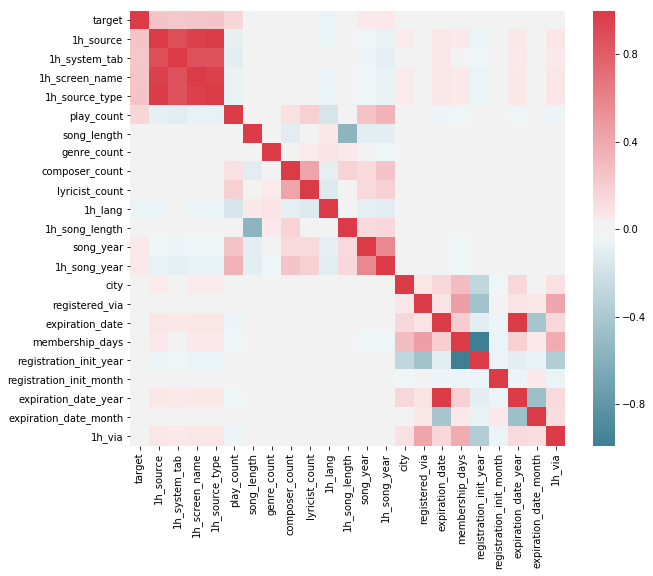

In [17]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

# LGBM training

In [18]:
train_set = lgb.Dataset(x, y)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'learning_rate': 0.2,
    'application': 'binary',
    'min_data_in_leaf': 10,
#    'max_depth': 10,
    'num_leaves': 2 ** 7,
    'max_bin': 255,
    'verbosity': 0,
    'metric': 'auc'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

# best_grid_params = custom_grid_search(params, grid_params, train_set, hold_out_set, num_boost_round=20)
# for key, val in best_grid_params.items():
#     params[key] = best_grid_params[key]

cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=100)
print(cv_score)

model = lgb.train(params, train_set=train_set, valid_sets=watchlist, num_boost_round=100, verbose_eval=5)
y_test = model.predict(x_test)

[5]	valid_0's auc: 0.655746	valid_1's auc: 0.671129
[10]	valid_0's auc: 0.663996	valid_1's auc: 0.682432
[15]	valid_0's auc: 0.671678	valid_1's auc: 0.692873
[20]	valid_0's auc: 0.676022	valid_1's auc: 0.69941
[25]	valid_0's auc: 0.679234	valid_1's auc: 0.704312
[30]	valid_0's auc: 0.681239	valid_1's auc: 0.707751
[35]	valid_0's auc: 0.682452	valid_1's auc: 0.710114
[40]	valid_0's auc: 0.683553	valid_1's auc: 0.712253
[45]	valid_0's auc: 0.684084	valid_1's auc: 0.713686
[50]	valid_0's auc: 0.68472	valid_1's auc: 0.715352
[55]	valid_0's auc: 0.684851	valid_1's auc: 0.716364
[60]	valid_0's auc: 0.684919	valid_1's auc: 0.717079
[65]	valid_0's auc: 0.68508	valid_1's auc: 0.717957
[70]	valid_0's auc: 0.685025	valid_1's auc: 0.718586
[75]	valid_0's auc: 0.685366	valid_1's auc: 0.719722
[80]	valid_0's auc: 0.685584	valid_1's auc: 0.720525
[85]	valid_0's auc: 0.68564	valid_1's auc: 0.72112
[90]	valid_0's auc: 0.685602	valid_1's auc: 0.721538
[95]	valid_0's auc: 0.685732	valid_1's auc: 0.722278

## Feature importances

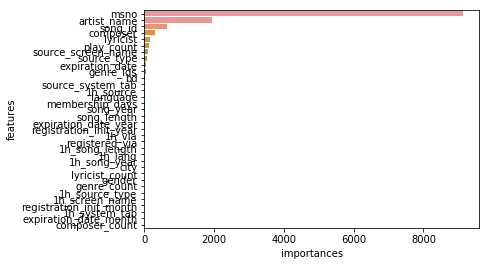

In [19]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

In [20]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
# string file compression reduces file size
submission_df.to_csv('data/submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        int64
target    float64
dtypes: float64(1), int64(1)
memory usage: 58.5 MB
